In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
#from network_class import Network


In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [4]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


In [14]:
def train_net(n_epochs, print_every ):

    steps = 0
    losses = []

    for e in range(n_epochs):

        model.train()
        running_loss = 0.0


        for images, labels in trainloader:
            steps += 1

            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # images batch to FFNW
            output = model.forward(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, labels)

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 299:
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)

                # print loss statistics
                print("Epoch: {}/{}.. ".format(e+1, n_epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                running_loss = 0

                # Make sure training is back on
                model.train()
        losses.append(running_loss)

    print('Finished Training')
    return losses



In [15]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256,128], drop_p=0.2)
print(model)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=516, bias=True)
    (1): Linear(in_features=516, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [16]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams
print_every = 300
losses = train_net(n_epochs,print_every)

Epoch: 1/10..  Training Loss: 0.699..  Test Loss: 0.510..  Test Accuracy: 0.811
Epoch: 1/10..  Training Loss: 0.499..  Test Loss: 0.465..  Test Accuracy: 0.835
Epoch: 1/10..  Training Loss: 0.465..  Test Loss: 0.435..  Test Accuracy: 0.845
Epoch: 2/10..  Training Loss: 0.374..  Test Loss: 0.444..  Test Accuracy: 0.834
Epoch: 2/10..  Training Loss: 0.425..  Test Loss: 0.431..  Test Accuracy: 0.847
Epoch: 2/10..  Training Loss: 0.406..  Test Loss: 0.399..  Test Accuracy: 0.859
Epoch: 3/10..  Training Loss: 0.289..  Test Loss: 0.404..  Test Accuracy: 0.856
Epoch: 3/10..  Training Loss: 0.383..  Test Loss: 0.422..  Test Accuracy: 0.841
Epoch: 3/10..  Training Loss: 0.377..  Test Loss: 0.403..  Test Accuracy: 0.853
Epoch: 4/10..  Training Loss: 0.223..  Test Loss: 0.370..  Test Accuracy: 0.867
Epoch: 4/10..  Training Loss: 0.350..  Test Loss: 0.399..  Test Accuracy: 0.856
Epoch: 4/10..  Training Loss: 0.362..  Test Loss: 0.381..  Test Accuracy: 0.865
Epoch: 5/10..  Training Loss: 0.166..  T

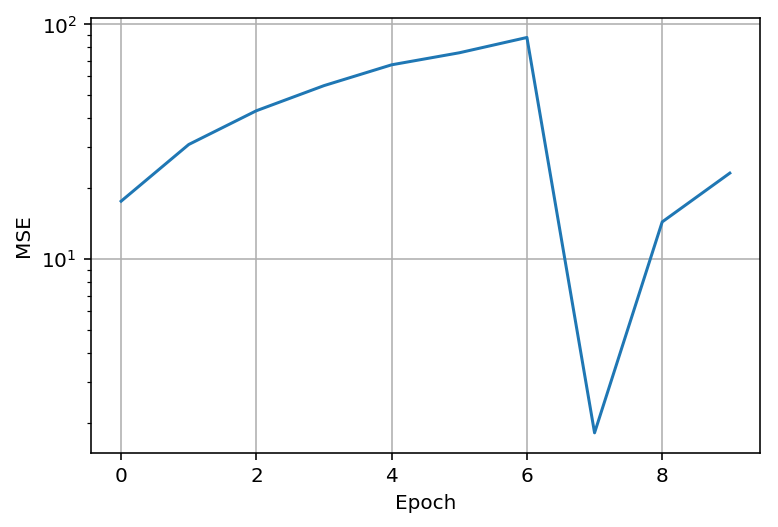

In [17]:
plt.figure(figsize=(10,8))
plt.semilogy(losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE');
plt.show()

In [36]:
#now we have the model trained we Inference

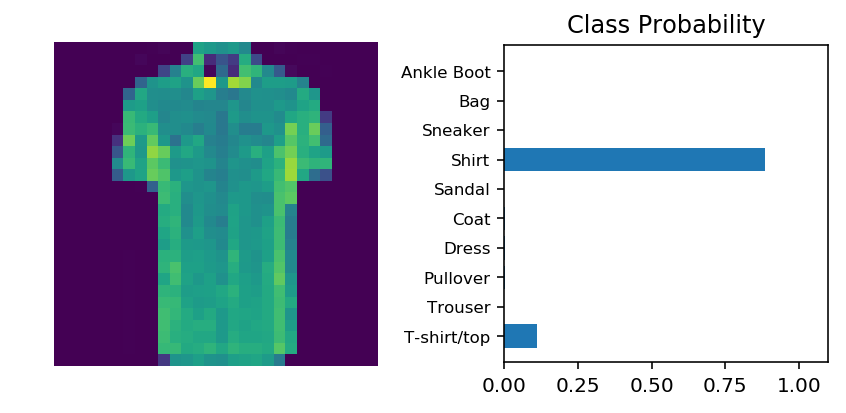

In [37]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')